In [6]:
import numpy as np
def rdnumpy(txtname):
    f = open(txtname)
    line = f.readlines()
    lines = len(line)  # row number
    for l in line:
        le = l.strip('\n').split(',')
        columns = len(le)-1  # col
        #print(le)
        #print(columns)
 
    A = np.zeros((lines, columns+1), dtype=np.single)
    print("read lines:",lines)
    print("read columns:",columns+1)
    A_row = 0
    for lin in line:
        #print(A_row)
        list = lin.strip('\n').split(',')
        A[A_row:] = list[0:columns+1]
        A_row += 1
    return A

In [7]:
#### Train &Test: 3360+1440

# Model

In [8]:
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import ToTensor, ToPILImage, Lambda
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [9]:
n_epochs = 3
batch_size_train = 6 #32,或者16-由於數據集比較小
batch_size_test = 1440*3
learning_rate = 0.001 #0.0001
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

# test

In [10]:
class ScottTrainDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        TrainDataf1=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\modelData\MTrainGf1.txt"))
        TrainDataw0=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\modelData\MTrainGw0.txt"))
        TrainDatam3=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\modelData\MTrainGm3.txt"))
        #TrainDataq4=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat16\MTrainGq4.txt"))
        
        self.AllTrainData=torch.cat((TrainDataw0,TrainDataf1,TrainDatam3),0)
        # 定义transform
        self.transform = transform
        self.target_transform = target_transform
 
    def __len__(self):
        '''返回数据集中的样本数'''
        return 288*3
 
    def __getitem__(self, index):#需要第index個的數據
        '''获取数据的方法，会和Dataloader连用'''
        i=index;        
        startRow=i*8;
        enRow=(i+1)*8;
        nowData=self.AllTrainData[startRow:enRow,2:7]
        
        if index>=0 and index<288:
            nowLabel=1
        elif index>=288 and index<288*2:
            nowLabel=0
        elif index>=288*2 and index<288*3:
            nowLabel=2
            
        if self.transform:
            nowData = self.transform(nowData)
        if self.target_transform:
            nowLabel = self.target_transform(nowLabel)
        '''
        if nowLabel==0:
            nowLabel = torch.FloatTensor([1, 0])
        else:
            nowLabel = torch.FloatTensor([0, 1])
        '''
        return nowData, nowLabel#需要返回數據和標簽

In [11]:
class ScottTestDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        TestDataf1=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\modelData\MTestGf1.txt"))
        TestDataw0=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\modelData\MTestGw0.txt"))
        TestDatam3=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\modelData\MTestGm3.txt"))
        #TestDataq4=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat16\MTestGq4.txt"))
        
        self.AllTrainData=torch.cat((TestDataw0,TestDataf1,TestDatam3),0)
        # 定义transform
        self.transform = transform
        self.target_transform = target_transform
 
    def __len__(self):
        '''返回数据集中的样本数'''
        return 132*3
 
    def __getitem__(self, index):#需要第index個的數據
        '''获取数据的方法，会和Dataloader连用'''
        i=index;        
        startRow=i*8;
        enRow=(i+1)*8;
        nowData=self.AllTrainData[startRow:enRow,2:7]
        
        if index>=0 and index<132:
            nowLabel=1
        elif index>=132 and index<132*2:
            nowLabel=0
        elif index>=132*2 and index<132*3:
            nowLabel=2
            
        if self.transform:
            nowData = self.transform(nowData)
        if self.target_transform:
            nowLabel = self.target_transform(nowLabel)
            
        '''
        if nowLabel==0:
            nowLabel = torch.FloatTensor([1, 0])
        else:
            nowLabel = torch.FloatTensor([0, 1])
        '''
            
        return nowData, nowLabel#需要返回數據和標簽

In [12]:
train_loader = torch.utils.data.DataLoader(ScottTrainDataset(),
    batch_size=batch_size_train, shuffle=True)


test_loader = torch.utils.data.DataLoader(ScottTestDataset(),
    batch_size=batch_size_test, shuffle=True)

read lines: 2304
read columns: 9
read lines: 2304
read columns: 9
read lines: 2304
read columns: 9
read lines: 1056
read columns: 9
read lines: 1056
read columns: 9
read lines: 1056
read columns: 9


# Network

In [13]:
#https://zhuanlan.zhihu.com/p/199624393
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=2, padding=1)
        self.conv2 = nn.Conv2d(10,20, kernel_size=3, padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(40, 15)
        self.fc2 = nn.Linear(15, 3)
    def forward(self, x):
        ##print(x)##
        #print("begin")
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print("relu1:")
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        #print("relu2:")
        #print(x.shape)
        x = x.view(-1,40)
        #print("view:")
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print("relu3:")
        #print(x.shape)
        x = F.dropout(x, training=self.training) 
        #print("dropout")
        #print(x.shape)
        x = self.fc2(x)
        #print("fc2")
        #print(x.shape)
        return F.log_softmax(x, dim=-1)
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [14]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

# Train

In [15]:
#for batch_idx, (data, target) in enumerate(train_loader):
        #print(data.shape)
        #print(data)

In [16]:
train_losses = []
train_counter = []

def train(epoch):
  for _ in range(epoch):
      network.train()
      for batch_idx, (data, target) in enumerate(train_loader):
        #if batch_idx>1920 and batch_idx<1920+320: continue
        optimizer.zero_grad()
        data = data.unsqueeze(1)
        #print(data.shape)
        #print(data)
        output = network(data)
        #print(target.shape, target, output)
        #assert 1==0
        #loss = F.binary_cross_entropy_with_logits(output, target)
        ##
        #print("output:")
        #print(output)
        #print("target:")
        #print(target)
        #print(target.shape)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        '''
        print(torch.isnan(data).sum(), (target==1).sum()+(target==0).sum())
        assert (target==1).sum()+(target==0).sum()==16
        print(torch.isnan(data).sum(), target.shape, target, output)
        if torch.isnan(output).sum()!=0:
            print(data, target, torch.isnan(data).sum())
            print(data[-5])
        assert torch.isnan(output).sum()==0
        assert torch.isnan(loss).sum()==0
        '''
        if batch_idx % log_interval == 0:
          #print(torch.isnan(data).sum(), target.shape, target, output)
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            _ , batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
          train_losses.append(loss.item())
          train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
          torch.save(network.state_dict(), './model.pth')
          torch.save(optimizer.state_dict(), './optimizer.pth')
          #print(network.state_dict())
    
train(50)

Train Epoch: 0 [0/864 (0%)]	Loss: 1.138414
Train Epoch: 0 [60/864 (7%)]	Loss: 1.105463
Train Epoch: 0 [120/864 (14%)]	Loss: 1.060879
Train Epoch: 0 [180/864 (21%)]	Loss: 1.031725
Train Epoch: 0 [240/864 (28%)]	Loss: 1.106783
Train Epoch: 0 [300/864 (35%)]	Loss: 1.116819
Train Epoch: 0 [360/864 (42%)]	Loss: 1.061371
Train Epoch: 0 [420/864 (49%)]	Loss: 1.038771
Train Epoch: 0 [480/864 (56%)]	Loss: 0.954656
Train Epoch: 0 [540/864 (62%)]	Loss: 0.955389
Train Epoch: 0 [600/864 (69%)]	Loss: 0.999001
Train Epoch: 0 [660/864 (76%)]	Loss: 0.927246
Train Epoch: 0 [720/864 (83%)]	Loss: 1.176910
Train Epoch: 0 [780/864 (90%)]	Loss: 0.928072
Train Epoch: 0 [840/864 (97%)]	Loss: 0.905272
Train Epoch: 1 [0/864 (0%)]	Loss: 0.578867
Train Epoch: 1 [60/864 (7%)]	Loss: 0.832285
Train Epoch: 1 [120/864 (14%)]	Loss: 0.619126
Train Epoch: 1 [180/864 (21%)]	Loss: 0.838372
Train Epoch: 1 [240/864 (28%)]	Loss: 0.684034
Train Epoch: 1 [300/864 (35%)]	Loss: 0.652727
Train Epoch: 1 [360/864 (42%)]	Loss: 0.77983

Train Epoch: 12 [480/864 (56%)]	Loss: 0.282618
Train Epoch: 12 [540/864 (62%)]	Loss: 0.036493
Train Epoch: 12 [600/864 (69%)]	Loss: 0.248593
Train Epoch: 12 [660/864 (76%)]	Loss: 0.076912
Train Epoch: 12 [720/864 (83%)]	Loss: 0.021720
Train Epoch: 12 [780/864 (90%)]	Loss: 0.395022
Train Epoch: 12 [840/864 (97%)]	Loss: 0.182093
Train Epoch: 13 [0/864 (0%)]	Loss: 0.059292
Train Epoch: 13 [60/864 (7%)]	Loss: 0.221076
Train Epoch: 13 [120/864 (14%)]	Loss: 0.139723
Train Epoch: 13 [180/864 (21%)]	Loss: 0.092009
Train Epoch: 13 [240/864 (28%)]	Loss: 0.082279
Train Epoch: 13 [300/864 (35%)]	Loss: 0.102093
Train Epoch: 13 [360/864 (42%)]	Loss: 0.207780
Train Epoch: 13 [420/864 (49%)]	Loss: 0.354760
Train Epoch: 13 [480/864 (56%)]	Loss: 0.065439
Train Epoch: 13 [540/864 (62%)]	Loss: 0.064197
Train Epoch: 13 [600/864 (69%)]	Loss: 0.102294
Train Epoch: 13 [660/864 (76%)]	Loss: 0.136456
Train Epoch: 13 [720/864 (83%)]	Loss: 0.310792
Train Epoch: 13 [780/864 (90%)]	Loss: 0.241138
Train Epoch: 13 [8

Train Epoch: 25 [0/864 (0%)]	Loss: 1.596376
Train Epoch: 25 [60/864 (7%)]	Loss: 0.096558
Train Epoch: 25 [120/864 (14%)]	Loss: 0.005770
Train Epoch: 25 [180/864 (21%)]	Loss: 0.671989
Train Epoch: 25 [240/864 (28%)]	Loss: 0.190227
Train Epoch: 25 [300/864 (35%)]	Loss: 0.009281
Train Epoch: 25 [360/864 (42%)]	Loss: 0.219972
Train Epoch: 25 [420/864 (49%)]	Loss: 0.530283
Train Epoch: 25 [480/864 (56%)]	Loss: 0.454906
Train Epoch: 25 [540/864 (62%)]	Loss: 0.196020
Train Epoch: 25 [600/864 (69%)]	Loss: 1.662055
Train Epoch: 25 [660/864 (76%)]	Loss: 0.040060
Train Epoch: 25 [720/864 (83%)]	Loss: 0.049935
Train Epoch: 25 [780/864 (90%)]	Loss: 0.284951
Train Epoch: 25 [840/864 (97%)]	Loss: 0.192950
Train Epoch: 26 [0/864 (0%)]	Loss: 0.064930
Train Epoch: 26 [60/864 (7%)]	Loss: 0.189335
Train Epoch: 26 [120/864 (14%)]	Loss: 0.185532
Train Epoch: 26 [180/864 (21%)]	Loss: 0.047913
Train Epoch: 26 [240/864 (28%)]	Loss: 0.077957
Train Epoch: 26 [300/864 (35%)]	Loss: 0.084930
Train Epoch: 26 [360/86

Train Epoch: 37 [360/864 (42%)]	Loss: 0.215415
Train Epoch: 37 [420/864 (49%)]	Loss: 0.050608
Train Epoch: 37 [480/864 (56%)]	Loss: 0.205536
Train Epoch: 37 [540/864 (62%)]	Loss: 0.030321
Train Epoch: 37 [600/864 (69%)]	Loss: 0.009665
Train Epoch: 37 [660/864 (76%)]	Loss: 0.097757
Train Epoch: 37 [720/864 (83%)]	Loss: 0.014937
Train Epoch: 37 [780/864 (90%)]	Loss: 0.007993
Train Epoch: 37 [840/864 (97%)]	Loss: 0.194093
Train Epoch: 38 [0/864 (0%)]	Loss: 1.570119
Train Epoch: 38 [60/864 (7%)]	Loss: 0.243323
Train Epoch: 38 [120/864 (14%)]	Loss: 0.080937
Train Epoch: 38 [180/864 (21%)]	Loss: 0.400795
Train Epoch: 38 [240/864 (28%)]	Loss: 0.557639
Train Epoch: 38 [300/864 (35%)]	Loss: 0.172004
Train Epoch: 38 [360/864 (42%)]	Loss: 0.012412
Train Epoch: 38 [420/864 (49%)]	Loss: 0.033883
Train Epoch: 38 [480/864 (56%)]	Loss: 0.056320
Train Epoch: 38 [540/864 (62%)]	Loss: 0.109791
Train Epoch: 38 [600/864 (69%)]	Loss: 0.016023
Train Epoch: 38 [660/864 (76%)]	Loss: 0.016115
Train Epoch: 38 [7

Train Epoch: 49 [720/864 (83%)]	Loss: 0.793916
Train Epoch: 49 [780/864 (90%)]	Loss: 0.157222
Train Epoch: 49 [840/864 (97%)]	Loss: 0.015144


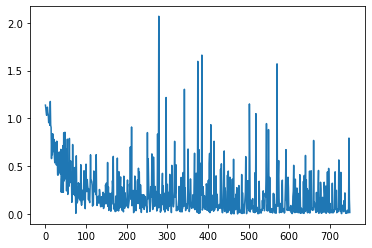

In [17]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt

plt.plot(list(range(len(train_losses))), train_losses)
plt.show()

In [18]:
'''
for p in network.parameters():
    print(p)
    break
tmp = torch.load('./model.pth')
network.load_state_dict(tmp)
for p in network.parameters():
    print(p)
    break
'''

"\nfor p in network.parameters():\n    print(p)\n    break\ntmp = torch.load('./model.pth')\nnetwork.load_state_dict(tmp)\nfor p in network.parameters():\n    print(p)\n    break\n"

In [19]:
import scipy.io as io
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.unsqueeze(1)
      #print("data:")
      #print(data.shape)
      output = network(data)
      #print("output:")
      #print(output.shape)
      
      test_loss += F.nll_loss(output, target, size_average=False).item()
      #print(output)
      pred = output.data.max(1, keepdim=True)[1]
      #print(pred)###
      result1 = np.array(pred)
      np.savetxt('pred.txt',result1)
      result2 = np.array(target)
      np.savetxt('target.txt',result2)
      
      #Save done
      correct += pred.eq(target.data.view_as(pred)).sum()
      
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    
test()


Test set: Avg. loss: 0.0224, Accuracy: 395/396 (99.75%)



C:\Users\PCI\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [20]:
'''
import scipy.io as io
result1 = np.array(result1)
np.savetxt('npresult1.txt',result1)
'''

"\nimport scipy.io as io\nresult1 = np.array(result1)\nnp.savetxt('npresult1.txt',result1)\n"

In [21]:
'''
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()
'''

"\nfor epoch in range(1, n_epochs + 1):\n  train(epoch)\n  test()\nimport matplotlib.pyplot as plt\nfig = plt.figure()\nplt.plot(train_counter, train_losses, color='blue')\nplt.scatter(test_counter, test_losses, color='red')\nplt.legend(['Train Loss', 'Test Loss'], loc='upper right')\nplt.xlabel('number of training examples seen')\nplt.ylabel('negative log likelihood loss')\nplt.show()\n"

# confusion matrix

In [22]:
  import scipy.io as io
  test_losses = []
  test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.unsqueeze(1)
      #print("data:")
      #print(data.shape)
      output = network(data)
      #print("output:")
      #print(output.shape)
      
      test_loss += F.nll_loss(output, target, size_average=False).item()
      #print(output)
      pred = output.data.max(1, keepdim=True)[1]
      #print(pred)###
      result1 = np.array(pred)
      #np.savetxt('pred.txt',result1)
      result2 = np.array(target)
      #np.savetxt('target.txt',result2)
      
      #Save done
      correct += pred.eq(target.data.view_as(pred)).sum()
      
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Avg. loss: 0.0224, Accuracy: 395/396 (100%)



In [23]:
from sklearn.metrics import f1_score
 
y_true = target
y_pred = pred
 
print(f1_score(y_true, y_pred, average='weighted'))# unbalance F1
print(f1_score(y_true, y_pred, average='macro'))
print()
print(f1_score(y_true, y_pred, average=None))
print("Acute       Normal      Chronic")

0.9974747112418395
0.9974747112418395

[0.99622642 1.         0.99619772]
Acute       Normal      Chronic


[[100.     0.     0.  ]
 [  0.   100.     0.  ]
 [  0.76   0.    99.24]]


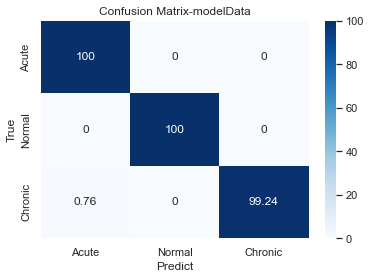

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

sns.set()
f,ax = plt.subplots()
y_true =(target)
y_pred = (pred)
C2 = confusion_matrix(y_true,y_pred,labels=[0,1,2])

fm=C2.sum(axis=1)
C3=C2/fm*100
C3=np.around(C3,decimals=2)

print(C3)
a=sns.heatmap(C3,annot=True,ax=ax, cmap = 'Blues', fmt='g') #画热力图  , cbar = None

ax.set_title('Confusion Matrix-modelData') #标题
ax.set_xlabel('Predict') #x 轴
ax.set_ylabel('True') #y 轴


#Normal, Acute, Chronic, Pre-seizure
a.set_xticklabels(['Acute','Normal','Chronic'])
a.set_yticklabels(['Acute','Normal','Chronic'])


fig = a.get_figure()
fig.savefig("6F_3C.png", dpi=1080)